In [1]:
from torch.autograd import Variable

In [2]:
import PIL
from PIL import Image
import numpy as np

In [3]:
from _model import ConvAutoencoder, collect_feature_maps
from _utils import *

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

### Load chosen image 

In [5]:
input_path = '../data/eagle.jpg'

img_pil = Image.open(input_path)
img_pil = crop_image_by_multiplier(img_pil, d=32)

img_np = pil_to_np(img_pil)
img_np.shape

(3, 480, 576)

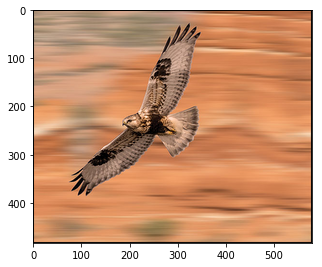

In [6]:
plot_image_grid([img_np], factor=4);

### Load model 

In [7]:
model = ConvAutoencoder()

# apply feature map collection hook
collect_feature_maps(model)

### Define optimization 

In [8]:
learning_rate = 1e-3
mse_loss = nn.MSELoss()

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate,
    weight_decay=1e-5)

### Train model for several epochs 

In [96]:
num_iter = 80

In [97]:
model.train()

X = torch.Tensor(img_np).unsqueeze(0)
X = Variable(X)

learning_curve = []
recon_curve = [torch_to_np(X)]

for epoch in range(num_iter):

    X_rec = model(X)  # inference
    
    loss = mse_loss(X_rec, X)
    learning_curve.append(loss)
    
    if epoch % 50 == 0:
        print("epoch:: {}, LOSS = {}".format(epoch + 1, loss))
        if epoch >= 10:
            recon_curve.append(torch_to_np(X_rec))
    
    loss.backward()
    optimizer.step()
    model.zero_grad()

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


epoch:: 1, LOSS = 0.009221447631716728
epoch:: 51, LOSS = 0.007419628091156483


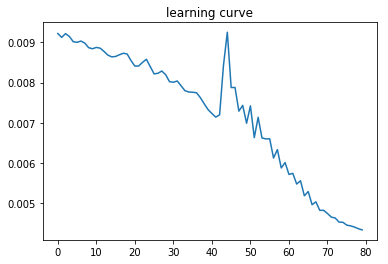

In [98]:
plt.plot(learning_curve);
plt.title('learning curve');

### Visualize reconstruction

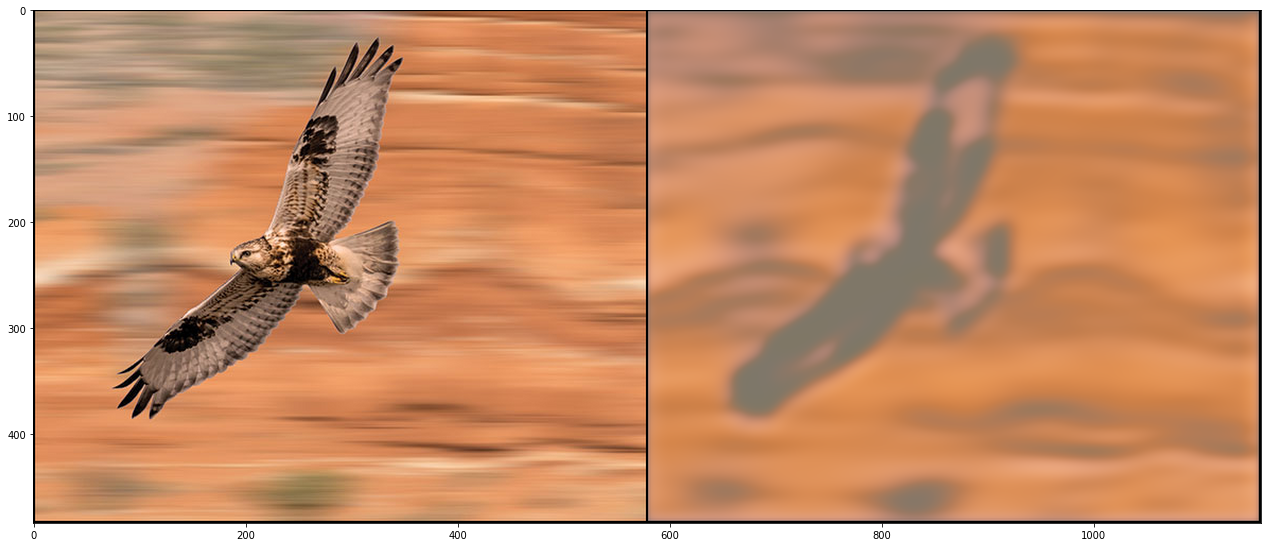

In [99]:
plot_image_grid(recon_curve, factor=20);

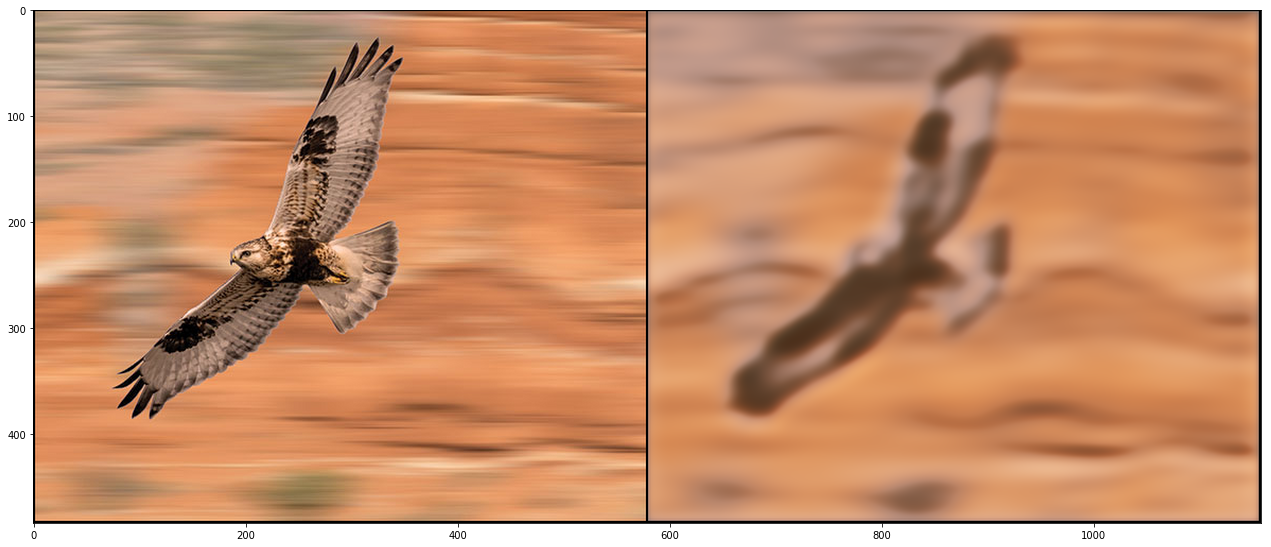

In [100]:
plot_image_grid([torch_to_np(X), torch_to_np(X_rec)], factor=20);

### Visualize feature maps 

In [101]:
feature_maps = model.feature_maps
feature_maps.keys()

odict_keys(['conv2d_1', 'conv2d_4', 'conv2d_7'])

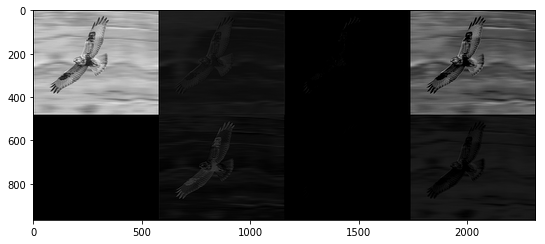

In [102]:
plot_image_grid(feature_maps['conv2d_1'], nrow=4);

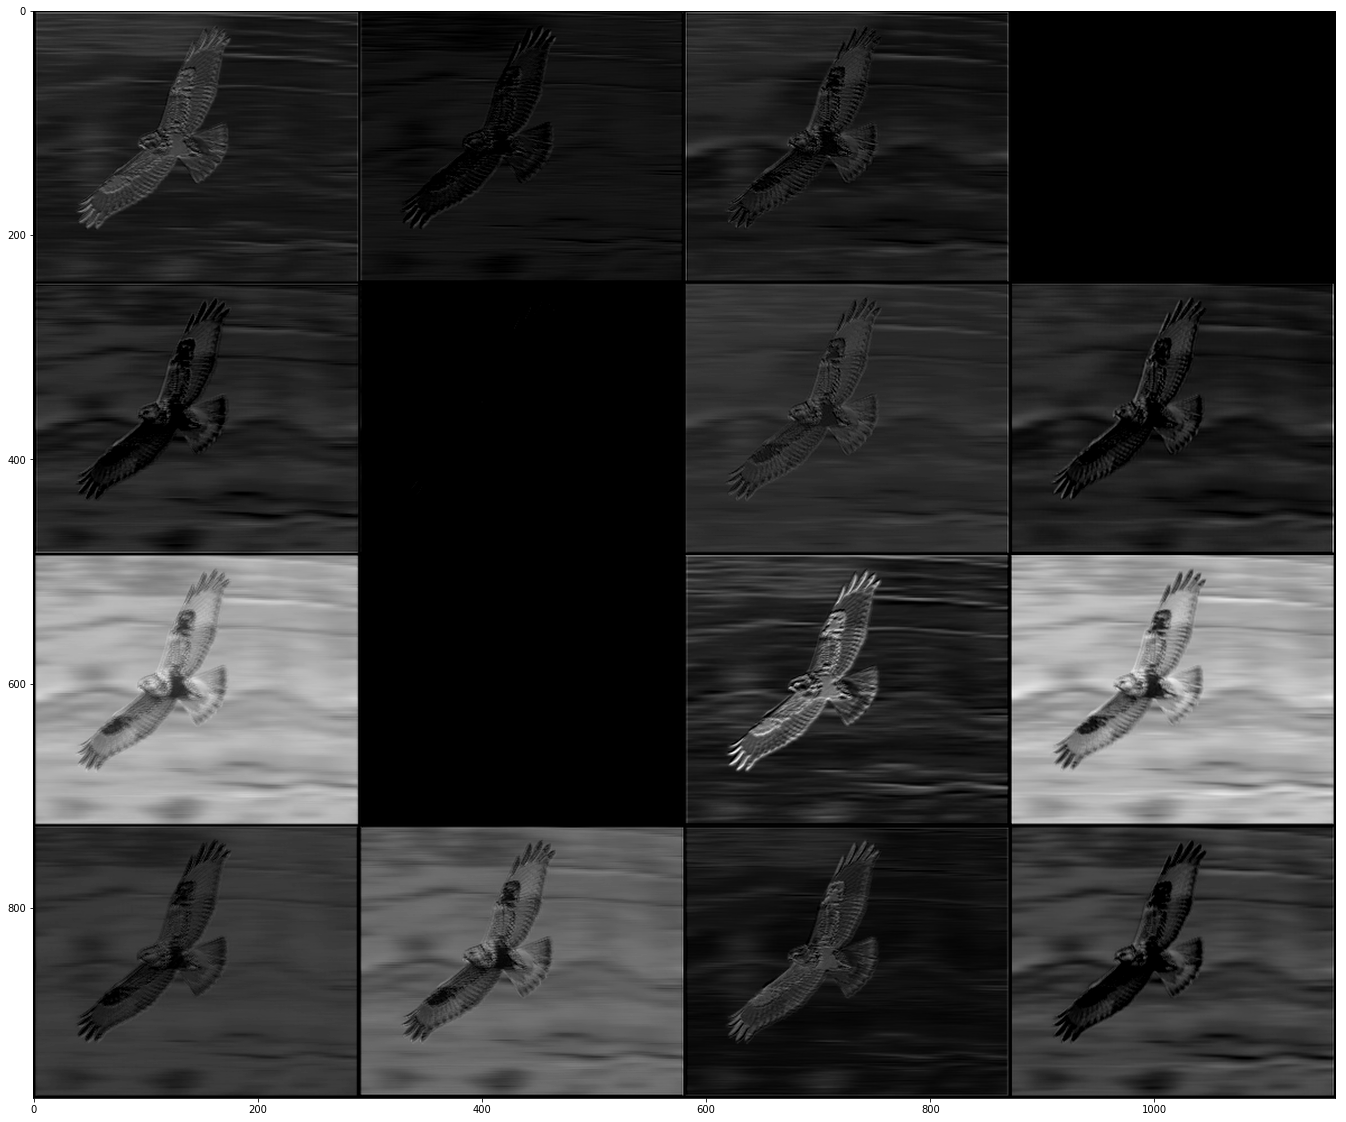

In [103]:
plot_image_grid(feature_maps['conv2d_4'], nrow=4, factor=8);

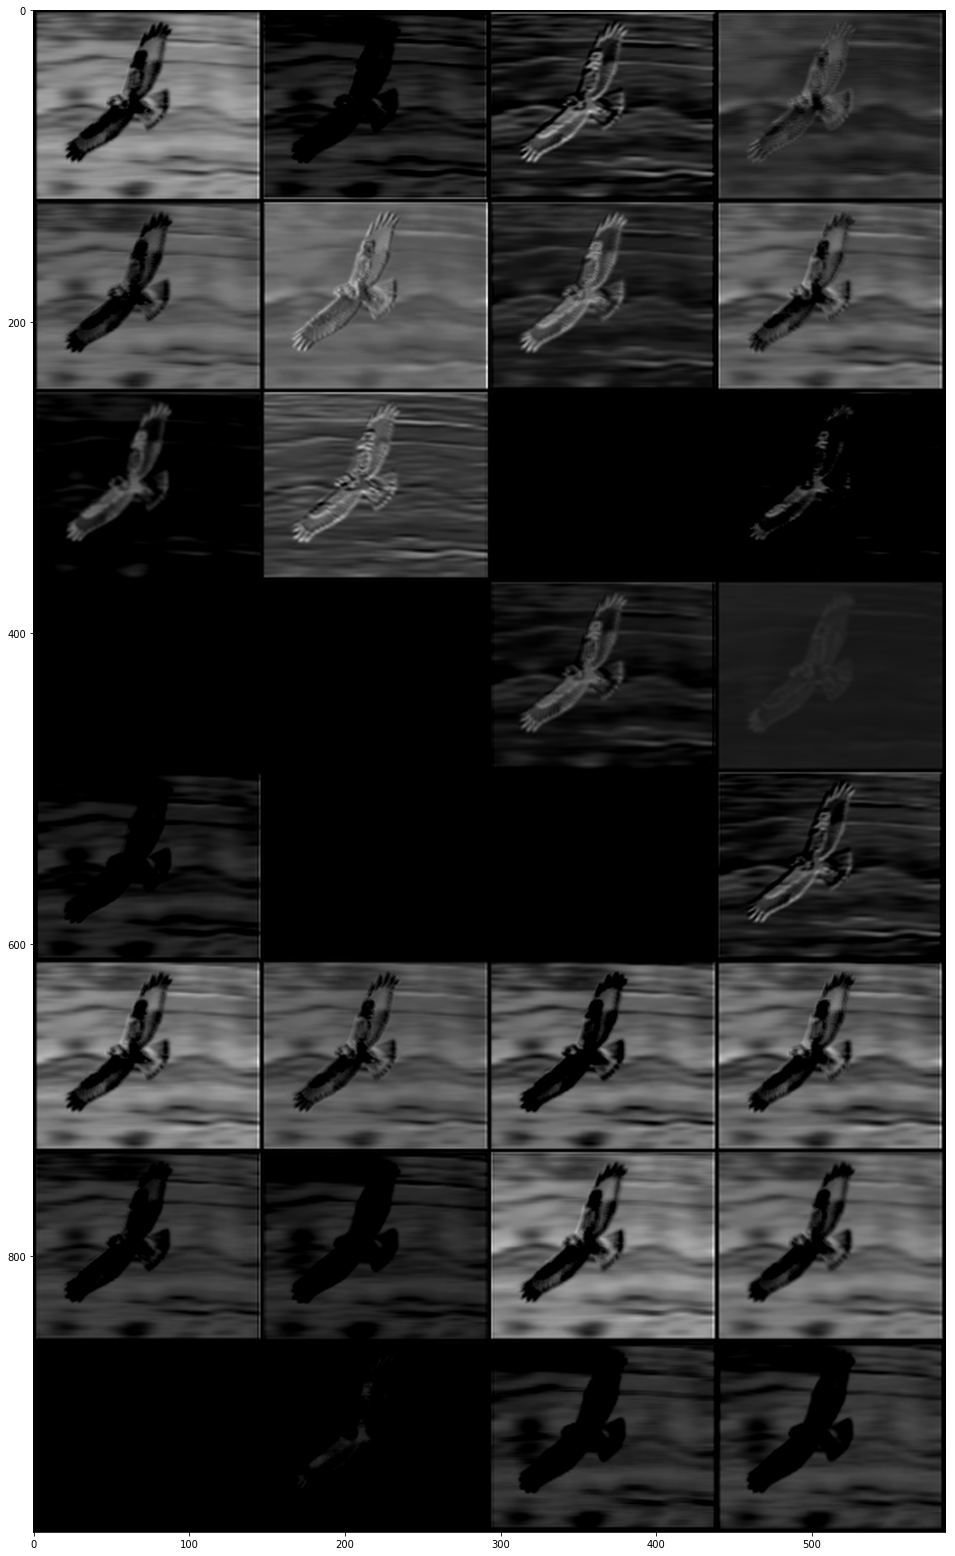

In [104]:
plot_image_grid(feature_maps['conv2d_7'], nrow=4, factor=16);

### Segment the Image 

In [105]:
def feature_maps_to_pixel_representation(feature_maps, n, m):
    
    _, n_fm, m_fm = feature_maps[0].shape
        
    feature_maps = [scipy.misc.imresize(fm.reshape(n_fm, m_fm), (n, m)) for fm in feature_maps]
    n_maps = len(feature_maps)
    data = np.array(feature_maps).reshape(n_maps, n * m).transpose()
    
    return data

In [106]:
def pixel_cluster_to_image_array(pixel_cluster, n, m):
    
    image_arr = pixel_cluster.transpose().reshape(n, m)
    return image_arr

In [107]:
data = feature_maps_to_pixel_representation(feature_maps['conv2d_4'], n=480, m=576)
data.shape

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """


(276480, 16)

In [108]:
from sklearn import cluster

In [113]:
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [114]:
pixel_cluster = kmeans.predict(data)
pixel_cluster.shape

(276480,)

In [115]:
cluster_image_arr = pixel_cluster_to_image_array(pixel_cluster, n=480, m=576)

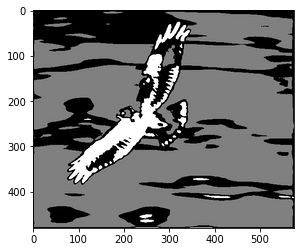

In [116]:
plt.imshow(cluster_image_arr, cmap='gray', interpolation='lanczos')